# Used Packages

In [1]:
import os
import shutil
import random

import pandas as pd
import spacy
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
from official.nlp import optimization
from IPython.display import display, HTML

import matplotlib.pyplot as plt
import matplotlib

In [2]:
css = """
.output {
    display: flex;
    flex-direction: row;
}
"""

HTML('<style>{}</style>'.format(css))

In [42]:
cmap_org = matplotlib.colors.LinearSegmentedColormap.from_list("", ["cornflowerblue","lime"], gamma=0.75)
cmap_new = plt.get_cmap("YlOrRd")

# Model Creation

In [4]:
PATH = 'data'
# set this parameter if you want to train another model
TRAIN_NEW_MODEL = False
NEW_MODEL_NAME = 'imdb2'

##  Dataset

In [5]:
# downloading the imdb dataset (if not already done)
# removing the unnecessary unsup folder because this is a supervised ml task
if not os.path.isdir('data'):
    url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

    dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                        untar=True, cache_dir=PATH,
                                        cache_subdir='')

    shutil.rmtree('unsup')

In [6]:
# setting the directory for the training and test data
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')

### Dataset Parameters

In [7]:
# setting model parameters
# autotune allows the automatic setting of the number of prefetched data ahead
# of time they are requested in the learning process
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 16
epochs = 1
seed = 42
init_lr = 3e-5

### Splitting Dataset

In [8]:
# training set 80 percent of all files with 20 left for validation
raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    train_dir, 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

val_ds = raw_val_ds.cache().prefetch(buffer_size=AUTOTUNE)

raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    test_dir, 
    batch_size=batch_size)

test_ds = raw_test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.
Found 25000 files belonging to 2 classes.


## Model Training

In [9]:
if TRAIN_NEW_MODEL:
    # setting the bert encoder and preprocessor
    tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'
    tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

    # generating the bert encoder and preprocess layer for the model
    # (save model error can be fixed by deleting temp folder)
    bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)
    bert_model = hub.KerasLayer(tfhub_handle_encoder)

    # function for building the classifiert model 
    # text input -> preprocessing -> encode -> droput -> dense 

    def build_classifier_model():
        text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
        preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
        encoder_inputs = preprocessing_layer(text_input)
        encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
        outputs = encoder(encoder_inputs)
        net = outputs['pooled_output']
        net = tf.keras.layers.Dropout(0.1)(net)
        net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
        return tf.keras.Model(text_input, net)

    # initialize classifier model
    classifier_model = build_classifier_model()

    # set loss and metric functions
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()

    # create model hyperparameter optimizer
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    optimizer = optimization.create_optimizer(init_lr=init_lr,
                                            num_train_steps=num_train_steps,
                                            num_warmup_steps=num_warmup_steps,
                                            optimizer_type='adamw')

    # early stopping 
    # early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss')

    # compile the model
    classifier_model.compile(optimizer=optimizer,
                            loss=loss,
                            metrics=metrics)

    # train the model
    history = classifier_model.fit(x=train_ds,
                                validation_data=val_ds,
                                epochs=epochs)

In [10]:
if TRAIN_NEW_MODEL:
    loss, accuracy = classifier_model.evaluate(test_ds)

In [11]:
if TRAIN_NEW_MODEL:
    saved_model_path = f'./models/{NEW_MODEL_NAME}_bert'
    classifier_model.save(saved_model_path, include_optimizer=False)

# Loading the Model and working with it

In [12]:
if not TRAIN_NEW_MODEL:
    saved_model_path = f'models/{os.listdir("models")[1]}'
    model = tf.keras.models.load_model(saved_model_path, compile=False)
else: 
    model = classifier_model

### Retrieve Complete Test Data

In [13]:
test_data_unbatched = list(test_ds.unbatch().as_numpy_iterator())

### Select Random Pair

In [14]:
rand_ind = random.randint(0, len(test_data_unbatched))
rand_sen_label_pair = test_data_unbatched[rand_ind]
rand_sen_label_pair[0]
# rand_sen_label_pair = ('Just a boring and uninspired film filled with bad acting.', 0)

b"MST3K fodder. It's so bad it's actually worth seeing just for that reason. There are some hilarious things in it, such as the mysterious device the bad guy is seen working on for the whole movie, that turns out to be this tiny helicopter that flutters around carrying and firing a machine gun without so much as a wobble, but is brought down by a bag of balloons (the kind they release at political conventions). Many other wonderful touches of that sort. Stars Charlie Sheen. There's one scene where he spends five minutes recording a conversation, only to drop the microcassette in the Potomac River by accident. If they'd cast Emilio Estevez in the part that never would've happened."

### Function for Text Classification

In [44]:
def classify_text(model, text, parent_ind=None, child_ind=None):
    '''
    Function to predict a given text given a model. 
    The predicted score is furthermore transformed into the corresponding 
    label.
    '''
    score = tf.sigmoid(model(tf.constant([text])))[0][0].numpy()
    pred_label = np.where(score > 0.5, 1, 0).item()

    return (score, pred_label, parent_ind, child_ind)
    

### Predict Random Pair Label and Score

In [16]:
org_text_pred = classify_text(model, rand_sen_label_pair[0])
print(f'Predicted Label: {org_text_pred[1]} \nScore: {org_text_pred[0]} \nReal Label: {rand_sen_label_pair[1]}')

Predicted Label: 0 
Score: 0.032090235501527786 
Real Label: 0


### Dependecy Parsing

In [17]:
depend_parser = spacy.load('en_core_web_sm')

In [18]:
parsed_text = depend_parser(str(rand_sen_label_pair[0]))
sentence_spans = list(parsed_text.sents)[0]

In [19]:
spacy.displacy.render(sentence_spans, jupyter=True, options={"compact": True})

### Functions for Text Generation

In [20]:
def leave_n_out(text):
    '''
    Function for generating texts from an original text, where every 
    text is missing a different parent-child-word-combination of 
    the original text.

    Go over all words, if a word has children, then for every parent-child-pair
    return a text with both removed.
    '''
    leave_n_out_texts = []

    for parent_to_remove in text:
        child_list = [child for child in parent_to_remove.children]

        if child_list:
            for child_to_remove in child_list:
                new_text = []

                for word in text:
                    if (word.i != parent_to_remove.i and 
                        word.i != child_to_remove.i):
                            new_text.append(word.text)

                leave_n_out_texts.append(
                    (" ".join(new_text), parent_to_remove.i, child_to_remove.i))

    return leave_n_out_texts


def leave_one_out(text):
    '''
    Function for generating texts from an original text, where 
    every text is missing one different word of the original text.
    '''
    leave_one_out_texts = []

    for word_to_remove in text:
        new_text = []

        for word in text:
            if word_to_remove.i != word.i:
                new_text.append(word.text)

        leave_one_out_texts.append(
            (" ".join(new_text), word_to_remove.i, None))

    return leave_one_out_texts

def leave_childs_out(text):
    '''
    Function for generating texts from an original text, where 
    every text is missing a prent word and all of it's children. 
    '''
    leave_childs_out_texts = []

    for word_to_remove in text:
        new_text = []
        child_ids = [child.i for child in word_to_remove.children]

        for word in text:
            if word_to_remove.i != word.i and word.i not in child_ids:
                new_text.append(word.text)

        leave_childs_out_texts.append(
            (" ".join(new_text), word_to_remove.i, child_ids))

    return leave_childs_out_texts

def leave_n_ancestors_out(text):
    '''
    Function for generating texts from an original text, where every 
    text is missing a different parent-ancestor-word-combination of 
    the original text.

    Go over all words, if a word has ancestors, then for every parent-ancestor-pair
    return a text with both removed.
    '''
    leave_n_out_texts = []

    for parent_to_remove in text:
        ancest_list = [ancest for ancest in parent_to_remove.ancestors]

        if ancest_list:
            for ancest_to_remove in ancest_list:
                new_text = []

                for word in text:
                    if (word.i != parent_to_remove.i and 
                        word.i != ancest_to_remove.i):
                            new_text.append(word.text)

                leave_n_out_texts.append(
                    (" ".join(new_text), parent_to_remove.i, ancest_to_remove.i))

    return leave_n_out_texts



### Functions for Further Processing

In [33]:
def drop_unimportant_words(df, label, org_score):
    '''
    Function to drop unimportant words.
    An unimportant word is one which increases 
    the difference of the classificaion with out it vs. with it .

    For example: "The movie was very good." 
    Score: 0.9
    Score without "the": 0.95

    "The" is unimportant, because the classification without it increases.
    '''
    if label == 1:
        df = df.drop(df.index[df['Score'] >= org_score] )
    else:
        df = df.drop(df.index[df['Score'] <= org_score] )

def calc_score_diff(df, label, org_score):
    '''
    Function to calculate the score differences of the original text to 
    those with certain words removed.
    '''
    if label == 1:
        df['Score Difference'] = org_score - df['Score']
    else:
        df['Score Difference'] = df['Score'] - org_score

def create_df(texts):
    '''
    Function to create a dataframe out of a given list of texts. 
    The constructed dataframe consists of four columns: 
    Score, Predicted Label, Parent Index and Child Index.

    The values for all columns come from the classify_text function.
    '''

    df = pd.DataFrame(
        [classify_text(model, text[0], text[1], text[2]) for text in texts],
        columns=['Score',
                 'Predicted Label',
                 'Parent Index',
                 'Child Index'])

    return df

def linearize_score_diff(df, choose_best_diff=False):
    '''
    Function to linearize the score differences in a given dataframe. 
    If choose_best_score flag is set, the best difference for every 
    token is choosen. 

    For example: 
    If the word "good" is a child of the word "movie" and the word "story"
    the best score difference of both pairs is choosen. If "good" happens
    to be a parent with children itself, all those possible pairs are 
    considered either for best difference. 
    '''
    if choose_best_diff:
        df_copy = df.copy()
        df_copy[['Child Index', 'Parent Index']
                ] = df[['Parent Index', 'Child Index']]
        df = pd.concat([df, df_copy]).reset_index(drop=True)
        df = df.loc[df.groupby(['Parent Index'])[
            "Score Difference"].idxmax()]

    df['Score Difference'] = MinMaxScaler(
    ).fit_transform(df[['Score Difference']])

    df.drop(
        ["Score", "Predicted Label", "Child Index"],
        inplace=True, axis=1)

    df = df.sort_values(by=['Score Difference'])

    df.rename(columns={"Parent Index": "Token Index"}, inplace=True)

    return df


### Functions for Visualization

In [34]:
def vis_text(df):
    '''
    Function which creates a plt plot without axis of a given text
    with given word importances. 

    It draws all words in a row, creating a new one whenever the current 
    row is to full. Words are colored given the corresponding importance 
    in the dataframe. 
    
    If a word is not given in the dataframe, for example if it was removed 
    due to not contributing to the classification, it is colored white.
    '''
    start_x = 20
    start_y = 500
    end = 1200
    whitespace = 8

    figure = plt.figure(figsize=(20, 10))
    rend = figure.canvas.get_renderer()

    for token in parsed_text:
        if df.loc[df["Token Index"] == token.i, 'Score Difference'].values.size > 0:
            col = cmap_new(df.loc[df["Token Index"] == token.i, 'Score Difference'].values[0])
        else: 
            col = "white"
        bbox = dict(boxstyle="round,pad=0.3", fc=col, ec="white")

        txt = plt.text(start_x, start_y, str(token), bbox=bbox, transform=None)

        bb = txt.get_window_extent(renderer=rend)

        start_x = bb.width + start_x + whitespace

        if start_x >= end:
            start_x = 20
            start_y -= 20

    plt.axis("off")
    plt.show()

## Generating New Texts

In [35]:
# Original Experiments
new_texts_lno = leave_n_out(parsed_text)
new_texts_loo = leave_one_out(parsed_text)

## Generating DataFrames

In [36]:
df_lno = create_df(new_texts_lno)
df_loo = create_df(new_texts_loo)

display(df_lno)
display(df_loo)

,Score,Predicted Label,Parent Index,Child Index
0,0.534107,1,2,0
1,0.222254,0,2,1
2,0.300089,0,2,3
3,0.174026,0,5,4
4,0.913136,1,5,7
...,...,...,...,...
127,0.028988,0,131,136
128,0.028988,0,136,132
129,0.028988,0,136,133
130,0.028988,0,136,134


,Score,Predicted Label,Parent Index,Child Index
0,0.013932,0,NaN,None
1,0.054840,0,1.0,None
2,0.254264,0,2.0,None
3,0.190622,0,3.0,None
4,0.088703,0,4.0,None
...,...,...,...,...
134,0.028988,0,134.0,None
135,0.028988,0,135.0,None
136,0.028988,0,136.0,None
137,0.028988,0,137.0,None


## Dropping Unimportant Words

In [37]:
drop_unimportant_words(df_lno, org_text_pred[1], org_text_pred[0])
drop_unimportant_words(df_loo, org_text_pred[1], org_text_pred[0])

## Calculating Score Differences

In [38]:
calc_score_diff(df_lno, org_text_pred[1], org_text_pred[0])
calc_score_diff(df_loo, org_text_pred[1], org_text_pred[0])

## Linearizing Score Difference

In [39]:
df_lno = linearize_score_diff(df_lno, choose_best_diff=True)
df_loo = linearize_score_diff(df_loo)

display(df_lno)
display(df_loo)

,Token Index,Score Difference
217,88,0.000000
219,93,0.000538
216,87,0.000589
156,85,0.000935
223,95,0.004782
...,...,...
221,91,0.621213
138,6,0.946297
4,5,0.964573
7,7,1.000000


,Token Index,Score Difference
88,88.0,0.000000
89,89.0,0.000244
85,85.0,0.001489
84,84.0,0.003766
90,90.0,0.006125
...,...,...
92,92.0,0.353335
6,6.0,0.429416
8,8.0,0.457565
86,86.0,0.760651


### Additional Experiments

In [40]:
# Removing the Parent and all Children before Classification
new_texts_lco = leave_childs_out(parsed_text)
df_lco = create_df(new_texts_lco)
drop_unimportant_words(df_lco, org_text_pred[1], org_text_pred[0])
calc_score_diff(df_lco, org_text_pred[1], org_text_pred[0])
df_lco = df_lco.explode('Child Index')
df_lco = linearize_score_diff(df_lco, choose_best_diff=True)

# Removing the Parent and all Ancesters (implicite Connections) before Classification
new_texts_lnao = leave_n_ancestors_out(parsed_text)
df_lnao = create_df(new_texts_lnao)
drop_unimportant_words(df_lnao, org_text_pred[1], org_text_pred[0])
calc_score_diff(df_lnao, org_text_pred[1], org_text_pred[0])
df_lnao = linearize_score_diff(df_lnao, choose_best_diff=True)

### Visualize Texts

Leave n out:


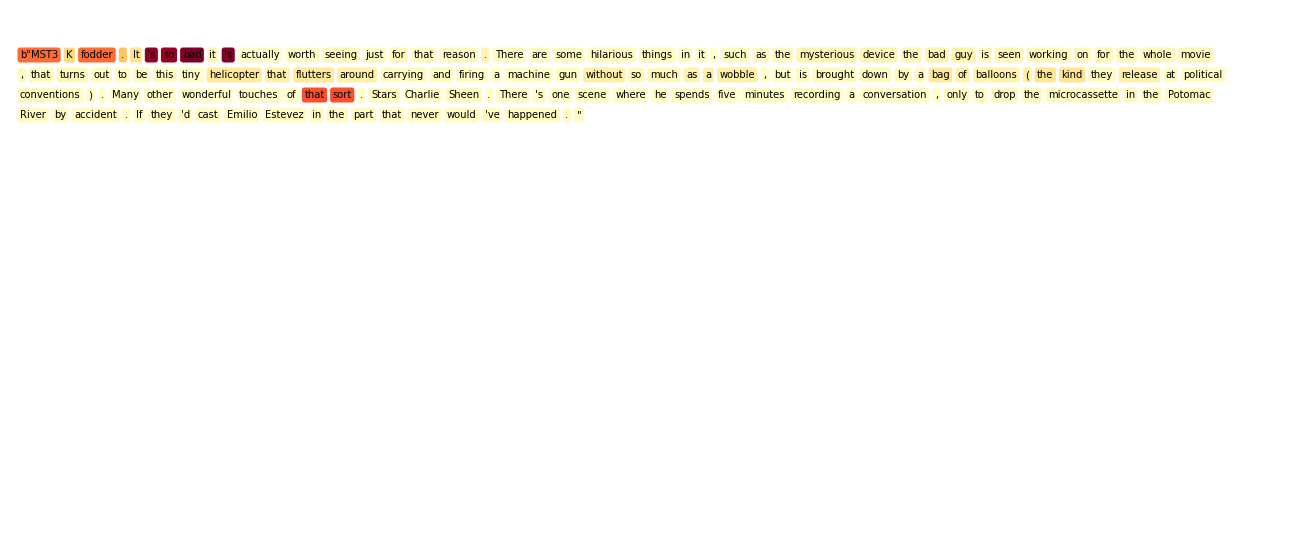

Leave all ancestors out


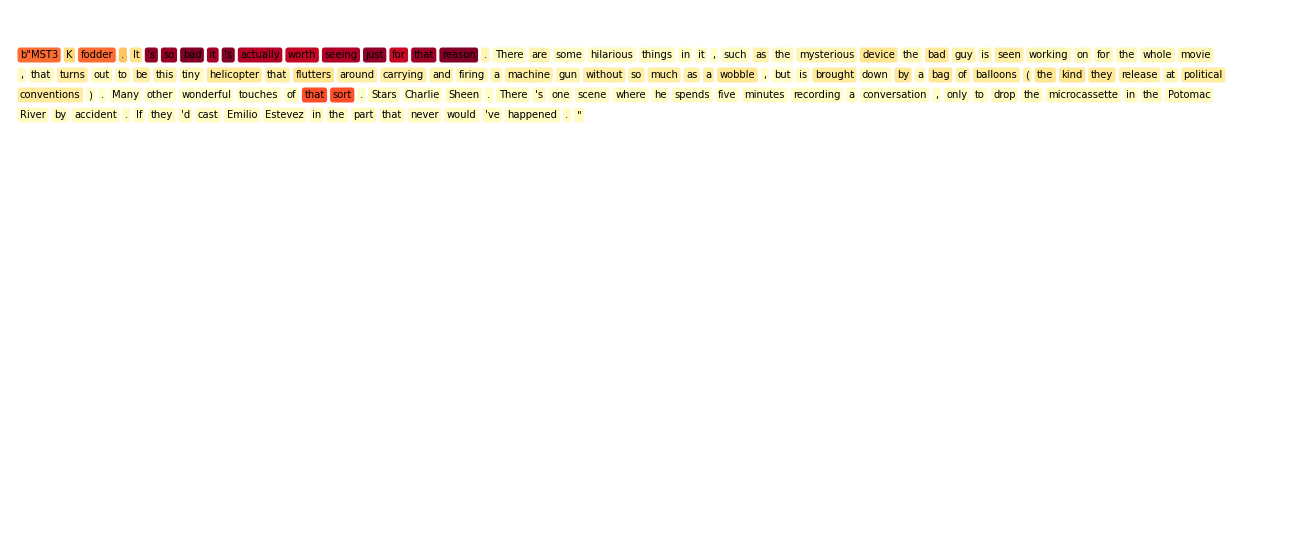

Leave children out


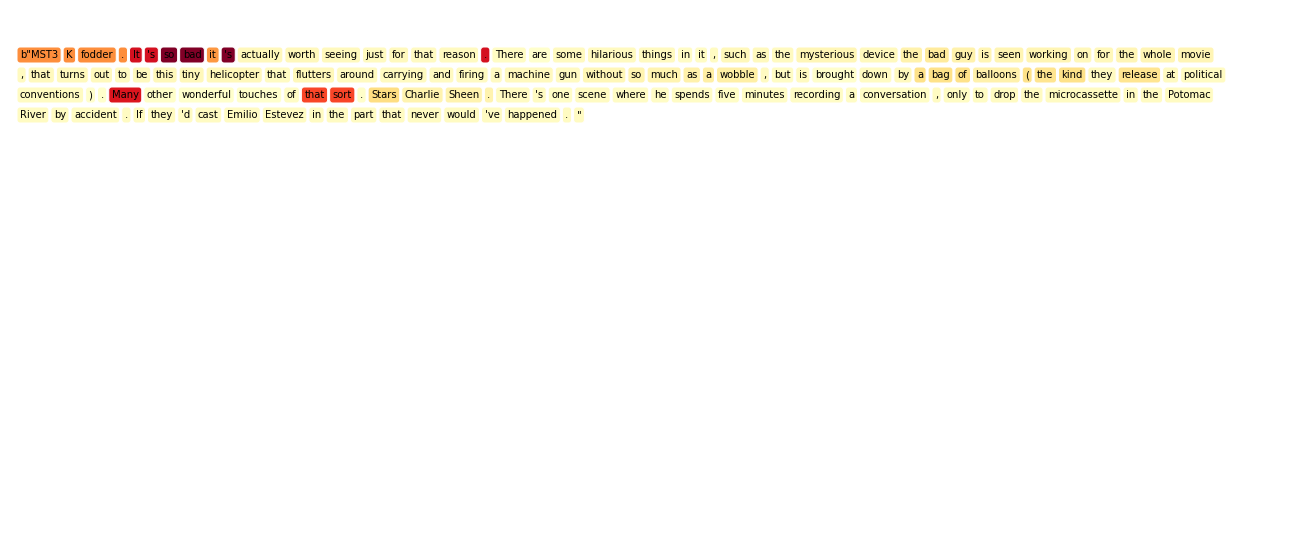

Leave one out:


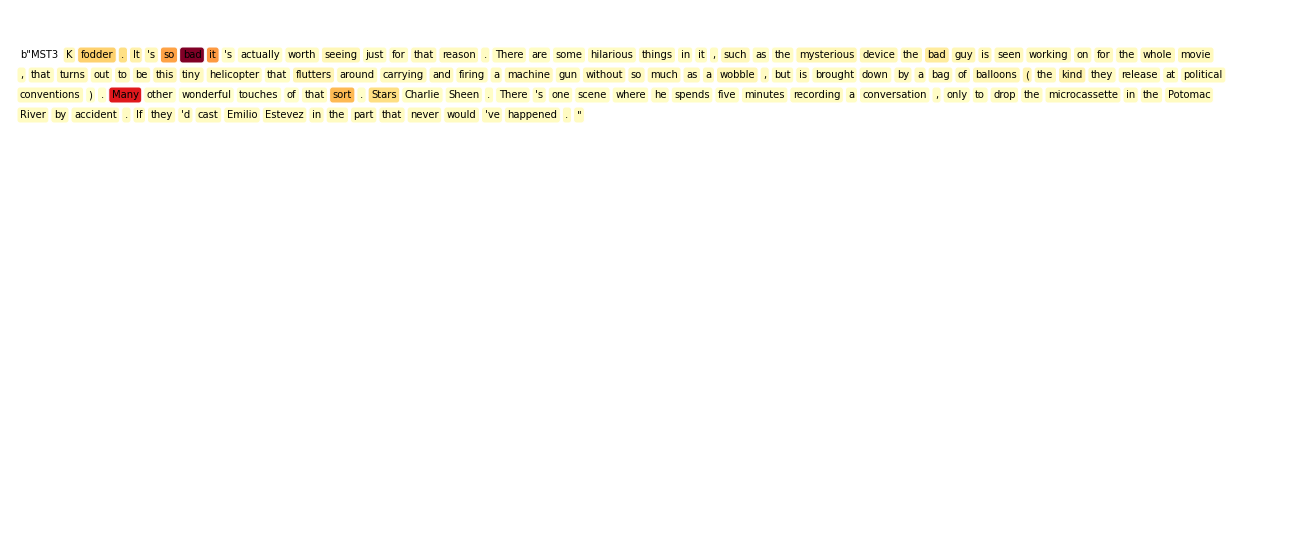

In [43]:
print('Leave n out:')
vis_text(df_lno)
print('Leave all ancestors out')
vis_text(df_lnao)
print('Leave children out')
vis_text(df_lco)
print('Leave one out:')
vis_text(df_loo)